In [1]:
import os
import sep
import glob
import fitsio
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Ellipse

from PyAstronomy import pyasl
from scipy.interpolate import interp1d
from photutils.detection import DAOStarFinder
from photutils.centroids import centroid_2dg

from astropy.coordinates import SkyCoord
from astropy.stats import sigma_clipped_stats
from astropy.stats import mad_std
import astropy.units as u
import astropy.constants as c
import astropy.coordinates as coord
from astropy.table import Table
from astropy.io import fits
from astropy.wcs import WCS
import scipy.integrate
from astropy.cosmology import FlatLambdaCDM
import requests
from PIL import Image
from io import BytesIO

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Define the database
Pan_mass_new = pd.read_csv('Pan_mass_new.csv')
Pan_mass = Pan_mass_new['mass']
Pan_mass_new.rename(columns={'name':'Names','mass':'Mass_Pan'}, inplace=True) # rename the column 'SNID'

FN_mass_reorder = pd.read_csv('FN_mass_reorder.csv')
FN_mass = FN_mass_reorder['mass']

FN_samples_host = pd.read_csv('FN_samples_host_info.csv')

In [3]:
# Compute observed distance modulus
# MB = -19.253
# alpha = 0.148
# beta = 3.09
# mB = list(FN_samples_host['mB'])
# mB = [mB[i] for i in range(len(mB)) if i not in missing_index]
# MU_ob = [mB[i]-MB for i in range(len(mB))] + (alpha*SN_lightcurves['x1'] - beta*SN_lightcurves['c'])
# FN_HR = pd.DataFrame(list(zip(Names_new, redshift, MU_SH0ES,MU_ob)), columns=['Names', 'zCMB', 'MU_SH0ES','MU_ob'])
FN_HR = pd.read_csv('FN_HR.csv')

In [4]:
# Merge the dataframes on the "Names" column
merged_HR_M = pd.merge(Pan_mass_new, FN_HR , on="Names")

median_M = merged_HR_M["Mass_Pan"].median()
sub1 = merged_HR_M[merged_HR_M["Mass_Pan"] <= median_M]
sub2 = merged_HR_M[merged_HR_M["Mass_Pan"] > median_M]

mean_M1 = np.mean(sub1["Mass_Pan"])
mean_HR1 = np.mean(sub1["HR"])

mean_M2 = np.mean(sub2["Mass_Pan"])
mean_HR2 = np.mean(sub2["HR"])


In [5]:
# Use Bootstrap to calculate errorbars, 1--low mass sample, 2--high mass sample
from scipy.stats import bootstrap
data1M = (np.array(sub1['Mass_Pan']), )
res1M = bootstrap(data1M, np.mean, confidence_level=0.9,method='percentile')
std_1M = res1M.standard_error
data1HR = (np.array(sub1['HR']), )
res1HR = bootstrap(data1HR, np.mean, confidence_level=0.9,method='percentile')
std_1HR = res1HR.standard_error

data2M = (np.array(sub2['Mass_Pan']), )
res2M = bootstrap(data2M, np.mean, confidence_level=0.9,method='percentile')
std_2M = res2M.standard_error
data2HR = (np.array(sub2['HR']), )
res2HR = bootstrap(data2HR, np.mean, confidence_level=0.9,method='percentile')
std_2HR = res2HR.standard_error

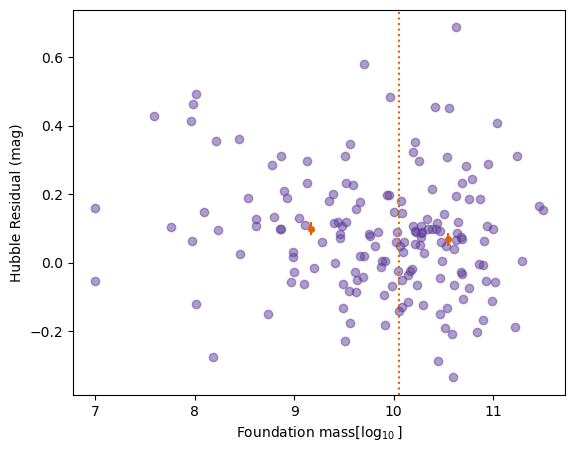

In [6]:
fig = plt.figure(figsize=(8, 5))
grid = plt.GridSpec(1, 2, width_ratios=[5, 1], wspace=0.1)
dots = np.linspace(7,12,6)
# Main scatter plot
ax_scatter = fig.add_subplot(grid[0])
ax_scatter.scatter(merged_HR_M["Mass_Pan"],merged_HR_M['HR'], alpha=0.5,color='#5e3c99')
ax_scatter.axvline(median_M,linestyle='dotted',color='#e66101',markersize=4)
# ax_scatter.plot(mean_M1,mean_HR1,'X',color='#e66101',markersize=10)
# ax_scatter.plot(mean_M2,mean_HR2,'X',color='#e66101',markersize=10)
ax_scatter.errorbar([mean_M1,mean_M2],[mean_HR1,mean_HR2],yerr=[std_1HR,std_2HR],fmt='o',color='#e66101',markersize=4)

ax_scatter.set_xlabel('Foundation mass[$\log_{10}$]')
ax_scatter.set_ylabel('Hubble Residual (mag)')
# ax_scatter.axes.set_xlim(0.2, 2.5)
# ax_scatter.axes.set_ylim(-0.25, 0.3)
#ax_scatter.legend()
#ax_scatter.legend(loc='lower right')
#plt.savefig('FN HR-M Pan.pdf')
plt.show()